In [1]:
!nvidia-smi

Tue Nov 15 13:41:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2022-11-15 13:41:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-15 13:41:40 (82.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,plot_loss_curves,compare_historys

In [4]:
import tensorflow_datasets as tfds

In [5]:
(train_data,test_data), ds_info = tfds.load("food101",
                                            split = ["train","validation"],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteE3WTR0/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteE3WTR0/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


For preprocess data before we use in our model

In [6]:
import tensorflow as tf

def preprocess_img(image,label,img_shape = 224):
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image, tf.float32), label

Getting data from tensorflow datasets

In [7]:
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img,
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [9]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

I really dont know why but gpu currently using cant not handle the mixed_float16

In [11]:
mixed_precision.set_global_policy(policy = "float32")

Creating first model

In [12]:
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax", dtype = tf.float32,name="softmax_float32")(x)

model=tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [15]:
history = model.fit(train_data,
                    batch_size=32,
                    epochs=3,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    steps_per_epoch=len(train_data),
                    callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                             experiment_name="efficientnet"),
                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet/20221115-134928
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7173 - accuracy: 0.5834

2368/2368 [==============================] - 198s 77ms/step - loss: 1.7173 - accuracy: 0.5834 - val_loss: 1.1370 - val_accuracy: 0.6981
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1991 - accuracy: 0.6891

2368/2368 [==============================] - 180s 75ms/step - loss: 1.1991 - accuracy: 0.6891 - val_loss: 1.0307 - val_accuracy: 0.7219
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.7240

2368/2368 [==============================] - 182s 76ms/step - loss: 1.0539 - accuracy: 0.7240 - val_loss: 1.0027 - val_accuracy: 0.7246


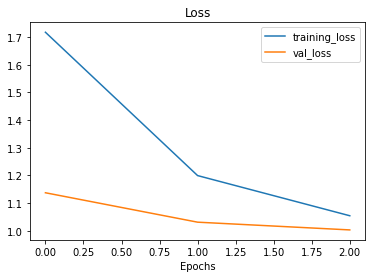

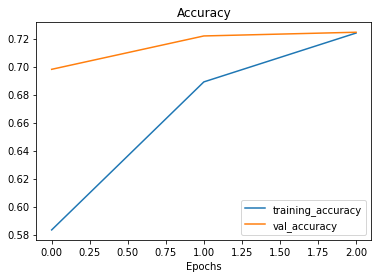

In [16]:
plot_loss_curves(history)

In [17]:
model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=["accuracy"])

I really dont know why fine-tuning doesnt work right here and the other model

In [19]:
history_1 = model.fit(train_data,
                    batch_size=32,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    steps_per_epoch=len(train_data),
                    initial_epoch = history.epoch[-1],
                    callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                             experiment_name="efficientnet"),
                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnet/20221115-135918
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9119 - accuracy: 0.7643

2368/2368 [==============================] - 183s 74ms/step - loss: 0.9120 - accuracy: 0.7643 - val_loss: 0.9973 - val_accuracy: 0.7246
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9120 - accuracy: 0.7643

2368/2368 [==============================] - 177s 74ms/step - loss: 0.9120 - accuracy: 0.7643 - val_loss: 1.0051 - val_accuracy: 0.7238
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9119 - accuracy: 0.7643

2368/2368 [==============================] - 180s 75ms/step - loss: 0.9120 - accuracy: 0.7643 - val_loss: 1.0022 - val_accuracy: 0.7238


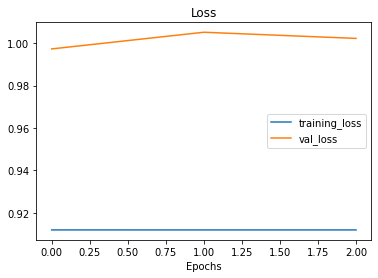

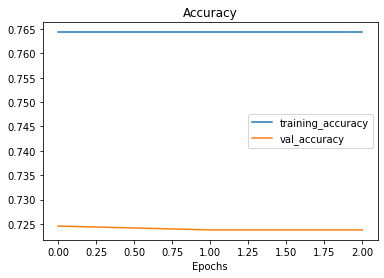

In [20]:
plot_loss_curves(history_1)

In [21]:
model.trainable = False
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.00004),
              metrics=["accuracy"])

I tried to get better results with making some layers trainable in our application model but It didn't worked

In [23]:
history_2 = model.fit(train_data,
                    batch_size=32,
                    epochs=8,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    initial_epoch = 6,
                    callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                             experiment_name="efficientnetb0"),
                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0/20221115-140908
Epoch 7/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.9119 - accuracy: 0.7643

2368/2368 [==============================] - 186s 75ms/step - loss: 0.9120 - accuracy: 0.7643 - val_loss: 1.0005 - val_accuracy: 0.7246
Epoch 8/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.9120 - accuracy: 0.7643

2368/2368 [==============================] - 180s 76ms/step - loss: 0.9120 - accuracy: 0.7643 - val_loss: 1.0019 - val_accuracy: 0.7246
